In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


In [6]:
folder_path = '/kaggle/input/xray-bone-fracture/xray_bone_fracture/'
training_path = folder_path + "train"
testing_path = folder_path + "val"

In [7]:
with strategy.scope():
    datagen = image.ImageDataGenerator(
        rotation_range=15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode='nearest',
        width_shift_range=0.1,
        height_shift_range=0.1
    )

In [8]:
with strategy.scope():
    training_generator = datagen.flow_from_directory(
        training_path,
        target_size = (224,224),
        batch_size = 16,
        shuffle=True,
        class_mode = 'binary')

    datagen.fit(training_generator.next()[0])

    training_generator = datagen.flow_from_directory(
        training_path,
        target_size = (224,224),
        batch_size = 16,
        shuffle=True,
        class_mode = 'binary')

    testing_generator = datagen.flow_from_directory(
        testing_path,
        target_size = (224,224),
        batch_size = 15,
        shuffle=True,
        class_mode = 'binary')



Found 8863 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [12]:
from tensorflow.keras.optimizers import Adam

def build_unet(inputs, ker_init, dropout, 
               filters_1=32, filters_2=64, filters_3=128,
               filters_4=256, filters_5=1024, units=1024):
    conv = Conv2D(filters_1, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv = Conv2D(filters_1, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv1 = Conv2D(filters_2, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    #conv1 = Conv2D(filters_2, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    conv1 = BatchNormalization()(conv1)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filters_3, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    #conv2 = Conv2D(filters_3, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    conv2 = BatchNormalization()(conv2)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filters_4, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool3)
    #conv3 = Conv2D(filters_4, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    conv3 = BatchNormalization()(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filters_5, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    #conv4 = Conv2D(filters_5, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv4)
    conv4 = BatchNormalization()(conv4)
    
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(filters_5, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool5)
    #conv5 = Conv2D(filters_5, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up1 = MaxPooling2D(pool_size=(2,2))(UpSampling2D(size = (2,2))(conv5))
    merge1 = concatenate([conv5,up1], axis = 3)
    conv6 = Conv2D(filters_5, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge1)
    #conv6 = Conv2D(filters_5, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up2 = Conv2D(filters_5, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv6))
    merge2 = concatenate([conv4,up2], axis = 3)
    
    pool7 = MaxPooling2D(pool_size=(3,3))(merge2)
    conv7 = Conv2D(filters_5, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool7)
    #conv7 = Conv2D(filters_5, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)
    conv7 = BatchNormalization()(conv7)

    up3 = Conv2D(filters_4, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (7,7))(conv7))
    merge3 = concatenate([conv3,up3], axis = 3)

    conv8 = Conv2D(filters_4, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge3)
    pool8 = MaxPooling2D(pool_size=(2, 2))(conv8)
    conv8 = Conv2D(filters_4, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool8)
    conv8 = BatchNormalization()(conv8)

    up4 = Conv2D(filters_3, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (4,4))(conv8))
    merge4 = concatenate([conv2,up4], axis = 3)
    pool9 = MaxPooling2D(pool_size=(2,2))(merge4)
    conv9 = Conv2D(filters_3, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool9)
    #conv9 = Conv2D(filters_3, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    conv9 = BatchNormalization()(conv9)
    
    up5 = Conv2D(filters_3, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (4,4))(conv9))
    merge5 = concatenate([conv1,up5], axis = 3)
    conv10 = Conv2D(filters_3, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge5)
    #conv10 = Conv2D(filters_3, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv10)
    conv10 = BatchNormalization()(conv10)

    up6 = Conv2D(filters_2, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv10))
    merge6 = concatenate([conv,up6], axis = 3)
    conv11 = Conv2D(filters_2, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge6)
    #conv11 = Conv2D(filters_2, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv11)
    conv11 = BatchNormalization()(conv11)

    conv_out = Conv2D(filters_3, (1,1), activation = 'relu')(conv11)
    conv_out = AveragePooling2D(pool_size=(2,2))(conv_out)

    global_avg = GlobalAveragePooling2D()(conv_out)
    fc1 = Dense(units,activation='relu')(global_avg)
    fc1 = BatchNormalization()(fc1)
    fc1 = GaussianNoise(0.25)(fc1)
    fc1 = Dropout(dropout)(fc1)

    fc2 = Dense(units,activation='relu')(fc1)
    fc2 = BatchNormalization()(fc2)
    fc2 = GaussianNoise(0.25)(fc2)
    fc2 = Dropout(dropout)(fc2)
    
    fc3 = Dense(units,activation='relu')(fc2)
    fc3 = BatchNormalization()(fc3)
    fc3 = GaussianNoise(0.25)(fc3)
    fc3 = Dropout(dropout)(fc3)

    outputs = Dense(1, activation='sigmoid')(fc3)

    return Model(inputs = inputs, outputs = outputs)

input_layer = Input((224, 224, 3))

with strategy.scope():
    UNet = build_unet(input_layer, 'normal', 0.2)
    opt = Adam(lr=0.01)
    UNet.compile(loss="binary_crossentropy", optimizer=opt, metrics = ['accuracy','Precision','Recall','AUC'])

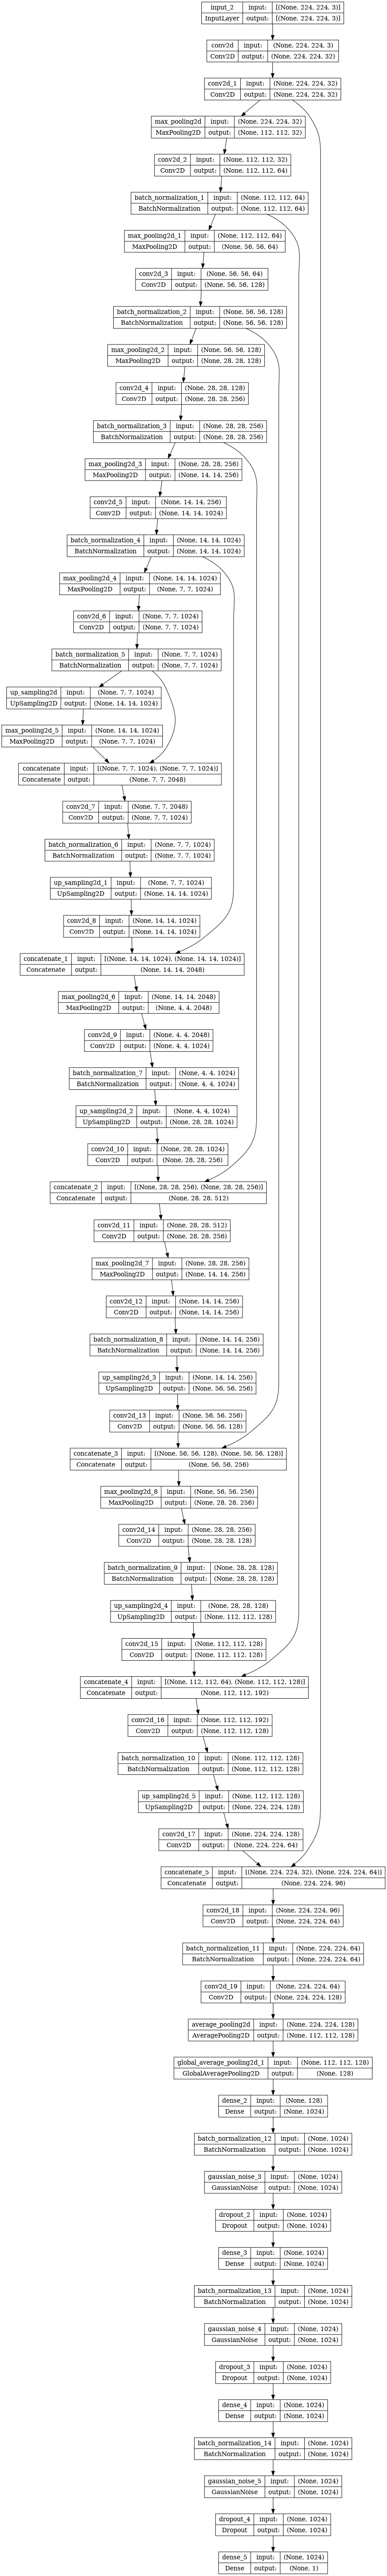

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(UNet,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [11]:
UNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [12]:
# filepath2 = 'best_model_2'
# lrp2 = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)
# checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# call2 = [checkpoint2,lrp2]

# history = UNet.fit(training_generator,
#                   validation_data=testing_generator,
#                   epochs=20,
#                   callbacks=call2)

Epoch 1/20


KeyboardInterrupt: 

In [13]:
import keras_tuner as kt

def generate_unet(hp):
    # Model
    filters_1 = hp.Int('filters', min_value=32, max_value=128, step=32)
    filters_2 = hp.Int('filters', min_value=32, max_value=256, step=32)
    filters_3 = hp.Int('filters', min_value=32, max_value=512, step=32)
    filters_4 = hp.Int('filters', min_value=32, max_value=1024, step=32)
    filters_5 = hp.Int('filters', min_value=32, max_value=2048, step=32)
    units = hp.Int('units', min_value=32, max_value=2048, step=32)
    dropout = hp.Float('rate', 0.1, 0.5)
    
    # Optimizer - Adam
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    beta_1 = hp.Float('beta_1', 0.5, 1)
    beta_2 = hp.Float('beta_1', 0.5, 1)
    
    kwargs_model = {'filters_1': filters_1,
                    'filters_2': filters_2,
                    'filters_3': filters_3,
                    'filters_4': filters_4,
                    'filters_5': filters_5,
                    'units': units,
                    'dropout': dropout}
    
    kwargs_optimizer = {'learning_rate': lr,
                        'beta_1': beta_1,
                        'beta_2': beta_2}
    
    input_layer = Input((224, 224, 3))
    
    with strategy.scope():
        unet = build_unet(input_layer, 'normal', **kwargs_model)
        opt = Adam(**kwargs_optimizer)
        unet.compile(loss="binary_crossentropy", optimizer=opt, metrics = ['accuracy','Precision','Recall','AUC'])
    
    return unet 

tuner = kt.BayesianOptimization(generate_unet,
                                 objective='val_accuracy',
                                 max_trials=10)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

STEP_SIZE_TRAIN=training_generator.n//training_generator.batch_size
STEP_SIZE_VALID=testing_generator.n//testing_generator.batch_size

filepath3 = 'tuner_1'

tuner_lrp = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=2)
tuner_checkpoint = ModelCheckpoint(filepath3, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
tuner_stop_early = EarlyStopping(monitor='val_accuracy', patience=3)
tuner_callbacks = [tuner_checkpoint, tuner_stop_early, tuner_lrp]

tuner.search(training_generator, 
             validation_data=testing_generator,
             steps_per_epoch=STEP_SIZE_TRAIN,
             validation_steps=STEP_SIZE_VALID, 
             epochs=20, 
             callbacks=tuner_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=15)[0]


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |filters
480               |480               |units
0.20439           |0.20439           |rate
0.001             |0.001             |learning_rate
0.59914           |0.59914           |beta_1

Epoch 1/20
553/553 [==============================] - ETA: 0s - loss: 0.7999 - accuracy: 0.5552 - precision: 0.5495 - recall: 0.5592 - auc: 0.5782
Epoch 1: val_accuracy improved from -inf to 0.68167, saving model to tuner_1
553/553 [==============================] - 162s 253ms/step - loss: 0.7999 - accuracy: 0.5552 - precision: 0.5495 - recall: 0.5592 - auc: 0.5782 - val_loss: 0.7261 - val_accuracy: 0.6817 - val_precision: 0.7526 - val_recall: 0.3042 - val_auc: 0.7455 - lr: 0.0010
Epoch 2/20
546/553 [============================>.] - ETA: 1s - loss: 0.6255 - accuracy: 0.6634 - precision: 0.6552 - recall: 0.6773 - auc: 0.7258

In [1]:
print(best_hps)

NameError: name 'best_hps' is not defined

In [ ]:
# Train with best hyperparameters
best_unet = tuner.hypermodel.build(best_hps)

history = best_unet.fit(training_generator, 
                        validation_data=testing_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=20, 
                        callbacks=call3)